# Gaussian Process Classification with Networks

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import scipy.optimize as so
import networkx as nx
import pandas as pd
import random

In [2]:
def int_to_list(nodes):
    if type(nodes) == int:
        return [nodes]
    else:
        return nodes
    
def net_kernel(Graph,graph_distance_matrix, nodes_a,nodes_b,theta,measnoise=1., wantderiv=True, print_theta=False):
    # Uses exp(theta) to ensure positive hyperparams
    nodes_a = int_to_list(nodes_a)
    nodes_b = int_to_list(nodes_b)
    theta = np.squeeze(theta)
    theta = np.exp(theta)
    #graph_distance_matrix = shortest_path_graph_distances(Graph)
    nodelist = list(Graph.nodes)
    nodeset = set(nodes_a).union(set(nodes_b))
    nodes_to_drop = [x for x in nodelist if x not in nodeset]
    cols_to_drop = set(nodes_to_drop).union(set(nodes_b) - set(nodes_a))
    rows_to_drop = set(nodes_to_drop).union(set(nodes_a) - set(nodes_b))
    p = graph_distance_matrix.drop(cols_to_drop).drop(rows_to_drop, 1)
    distances = p.values
    
    d1 = len(nodes_a)
    d2 = len(nodes_b)
  
    k = theta[0] * np.exp(-0.5*distances)
    
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*distances
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)
    

def net_logPosterior(theta,*args):
    Graph, distmatrix,data,targets = args
    (f,logq,a) = net_NRiteration(Graph, distmatrix, data,targets,theta)
    return -logq

def net_NRiteration(Graph, distmatrix,data,targets,theta):
    #print("iteration")
    #pag 46 RASMUSSEN-WILLIAMS
    K = net_kernel(Graph, distmatrix, data, data, theta, wantderiv=False)
    #K = net_kernel(data,data,theta,wantderiv=False)
    n = np.shape(targets)[0]
    f = np.zeros((n,1))
    tol = 0.1
    phif = 1e100
    scale = 1.
    count = 0
    targets = targets.values.reshape(n,1)
    while True:	
        
        count += 1
        s = np.where(f<0,f,0)
        W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
        sqrtW = np.sqrt(W)
        # L = cholesky(B)
        L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K,sqrtW)))
        p = np.exp(s)/(np.exp(s) + np.exp(s-f))
        b = np.dot(W,f) + 0.5*(targets+1) - p
        a = scale*(b - np.dot(sqrtW,np.linalg.solve(L.transpose(),np.linalg.solve(L,np.dot(sqrtW,np.dot(K,b))))))
        f = np.dot(K,a)
        oldphif = phif
        phif = np.log(p) -0.5*np.dot(f.transpose(),np.dot(np.linalg.inv(K),f)) - 0.5*np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
        #print(phif)
        #print("loop",np.sum((oldphif-phif)**2))
        if (np.sum((oldphif-phif)**2) < tol):	
            break
        elif (count > 100):
            count = 0
            scale = scale/2.
    s = -targets*f
    ps = np.where(s>0,s,0)
    #logq = -0.5*np.dot(a.transpose(),f) -np.sum(np.log(ps+np.log(np.exp(-ps) + np.exp(s-ps)))) - np.trace(np.log(L))
    logq = -0.5*np.dot(a.transpose(),f) -np.sum(np.log(ps+np.log(np.exp(-ps) + np.exp(s-ps)))) - sum(np.log(L.diagonal()))
    return (f,logq,a)


def net_gradLogPosterior(theta,*args):
    Graph, distmatrix, data,targets = args
    theta = np.squeeze(theta)
    n = np.shape(targets)[0]
    K = net_kernel(Graph, distmatrix, data, data, theta, wantderiv=True)
    # K = kernel(data,data,theta,wantderiv=True)
    (f,logq,a) = net_NRiteration(Graph, distmatrix, data,targets,theta)
    s = np.where(f<0,f,0)
    W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
    sqrtW = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K[:,:,0],sqrtW)))
    
    R = np.dot(sqrtW,np.linalg.solve(L.transpose(),np.linalg.solve(L,sqrtW)))
    C = np.linalg.solve(L,np.dot(sqrtW,K[:,:,0]))
    p = np.exp(s)/(np.exp(s) + np.exp(s-f))
    hess = -np.exp(2*s - f) / (np.exp(s) + np.exp(s-f))**2
    s2 = -0.5*np.dot(np.diag(np.diag(K[:,:,0]) - np.diag(np.dot(C.transpose(),C))) , 2*hess*(0.5-p))
    
    targets = targets.values.reshape(n,1)
    
    gradZ = np.zeros(len(theta))
    for d in range(1,len(theta)+1):
        s1 = 0.5*(np.dot(a.transpose(),np.dot(K[:,:,d],a))) - 0.5*np.trace(np.dot(R,K[:,:,d]))	
        b = np.dot(K[:,:,d],(targets+1)*0.5-p)
        p = np.exp(s)/(np.exp(s) + np.exp(s-f))
        s3 = b - np.dot(K[:,:,0],np.dot(R,b))
        gradZ[d-1] = s1 + np.dot(s2.transpose(),s3)

    return -gradZ

def net_predict(Graph, distmatrix, xstar,data,targets,theta):
    K = net_kernel(Graph, distmatrix, data,data,theta,wantderiv=False)
    n = np.shape(targets)[0]
    kstar = net_kernel(G, dist, data,xstar,theta,wantderiv=False,measnoise=0)
    (f,logq,a) = net_NRiteration(Graph, distmatrix, data,targets,theta)
    targets = targets.values.reshape(n,1)
    s = np.where(f<0,f,0)
    W = np.diag(np.squeeze(np.exp(2*s - f) / ((np.exp(s) + np.exp(s-f))**2)))
    sqrtW = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(n) + np.dot(sqrtW,np.dot(K,sqrtW)))
    p = np.exp(s)/(np.exp(s) + np.exp(s-f))
    fstar = np.dot(kstar.transpose(), (targets+1)*0.5 - p)
    v = np.linalg.solve(L,np.dot(sqrtW,kstar))	
    V = net_kernel(G, dist, xstar,xstar,theta,wantderiv=False,measnoise=0)-np.dot(v.transpose(),v) 
    return (fstar,V)

def shortest_path_graph_distances(Graph):
    shortest_paths_lengths = dict(nx.all_pairs_shortest_path_length(Graph))
    dist = pd.DataFrame(shortest_paths_lengths).sort_index(axis=1)
    return dist

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


In [3]:
lattice_m = 15
lattice_n = 15
N = 100     # numero punti training
n = 90    # numero punti test
ntest = 9
deg = 4 #connectivity degree
#%%
#G = nx.random_regular_graph(deg, N+n + 10)
G = nx.generators.lattice.grid_graph(dim = [lattice_m,lattice_n],periodic= False)
G = nx.relabel_nodes(G, dict(zip(G,range(len(G.nodes)))))

In [4]:
random.seed(0)

#training_nodes = list(G.nodes)[0:N]
training_nodes = random.sample(list(G.nodes), N)
training_nodes.sort()

#test_nodes = list(G.nodes)[N:N+n]
test_nodes = random.sample((set(G.nodes) - set(training_nodes)), n)
test_nodes.sort()

othernodes = set(G.nodes) - set(training_nodes) - set(test_nodes)
othernodes = list(othernodes)
othernodes.sort()

In [5]:
dist = shortest_path_graph_distances(G)

nodes_dataframe = pd.DataFrame({"nodes": list(G.nodes)})
nodes_dataframe["training_node"] = nodes_dataframe["nodes"].isin(training_nodes)
nodes_dataframe["test_node"] = nodes_dataframe["nodes"].isin(test_nodes)
nodes_dataframe["test_node"] = nodes_dataframe["nodes"].isin(test_nodes)
nodes_dataframe["other_node"] = nodes_dataframe["nodes"].isin(othernodes)

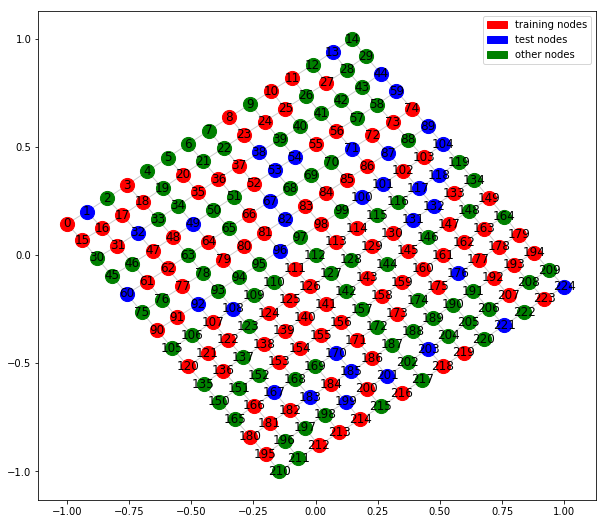

In [6]:
#pl.figure(0, dpi=200, figsize=[12,7])
pl.figure(0, figsize = [10,9])
#node positions
pos = nx.kamada_kawai_layout(G)
#draw nodes
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=training_nodes, node_color="r")
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=test_nodes, node_color="g")
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=200, nodelist=othernodes, node_color="b")
#draw edges
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
#legend
graph_labels = nx.draw_networkx_labels(G, pos=pos, font_color='k')
red_patch = mpatches.Patch(color='red', label='training nodes')
blue_patch = mpatches.Patch(color='blue', label='test nodes')
green_patch = mpatches.Patch(color='green', label='other nodes')
pl.legend(handles=[red_patch, blue_patch, green_patch])

pivot_distance = pd.Series(dict(nx.single_source_shortest_path_length(G,0))).sort_index()
nodes_dataframe["pivot_distance"] = pivot_distance
#t = pivot_distance[training_nodes]
t = nodes_dataframe["pivot_distance"][nodes_dataframe["training_node"]==True]
binary_labels = (np.sin(0.5*pivot_distance)>0).replace({True: 1, False: -1})
nodes_dataframe["binary_label"] = binary_labels

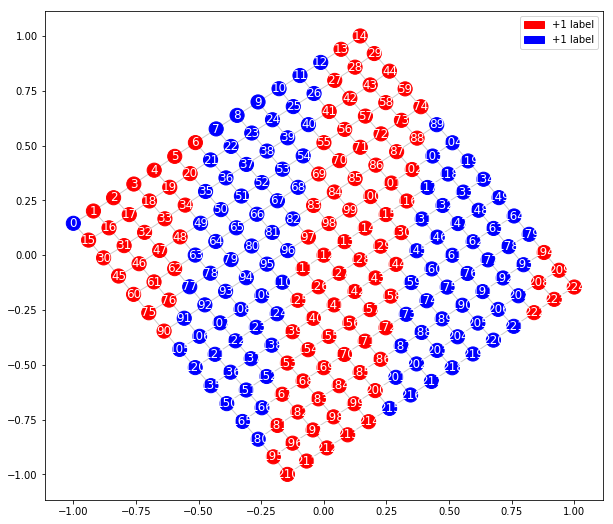

In [7]:
pl.figure(1, figsize=[10,9])
#cmap = pl.cm.bwr
#sm = pl.cm.ScalarMappable(cmap=cmap, norm=pl.Normalize(vmin -1, vmax= +1))
#sm.set_array([])
#cbar = pl.colorbar(sm)
red_binary_patch = mpatches.Patch(color="red", label='+1 label')
blue_binary_patch = mpatches.Patch(color="blue", label='+1 label')
nx.draw_networkx_nodes(G,pos, node_color=binary_labels,with_labels=True, node_size=200, cmap=pl.cm.bwr)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
graph_labels = nx.draw_networkx_labels(G, pos=pos, font_color='w')
pl.legend(handles=[red_binary_patch, blue_binary_patch])

In [8]:
training_labels = binary_labels[training_nodes]
theta =np.zeros((3,1))
theta[0] =-2.72
theta[1] = +4
theta[2] =-4
newtheta = so.fmin_cg(net_logPosterior, theta, fprime=net_gradLogPosterior, args=(G, dist,training_nodes,training_labels), gtol=1e-4,maxiter=1000,disp=1, full_output=0)
print(newtheta, net_logPosterior(newtheta,G, dist, training_nodes,training_labels))

if newtheta.shape == (1,3):
    print("l'ottimizzatore fa i capricci, cambio dimensioni")
    newtheta = newtheta[0]

         Current function value: -39.509756
         Iterations: 0
         Function evaluations: 29
         Gradient evaluations: 18
[-2.72  4.   -4.  ] [[-39.5097561]]


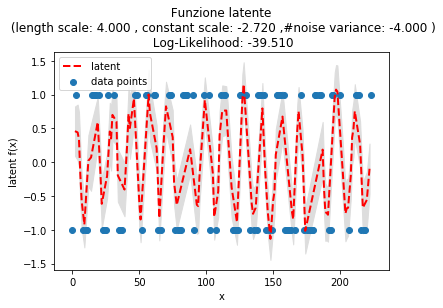

In [9]:
kstar = net_kernel(G, dist, test_nodes, training_nodes, newtheta, wantderiv=False,measnoise=False)
K = net_kernel(G, dist, training_nodes,training_nodes,newtheta,wantderiv=False)
kstarstar = net_kernel(G, dist, test_nodes,test_nodes, newtheta, wantderiv=False, measnoise=False)
kstarstar_diag = kstarstar.diagonal()

invk = np.linalg.inv(K)
mean = np.dot(kstar,np.dot(invk,training_labels))
var = kstarstar_diag - np.diag(np.dot(kstar,np.dot(invk,kstar.transpose())))
var = np.reshape(var,(n,1))
#%%
xstar_p = np.squeeze(test_nodes)
mean_p = np.squeeze(mean)
var_p = np.squeeze(np.reshape(var,(len(test_nodes),1)))
s = np.sqrt(var_p)

pl.figure()
pl.clf()

pl.gca().fill_between(xstar_p,mean_p - 2*s,mean_p +2*s,color="#dddddd")
latent, = pl.plot(xstar_p, mean, 'r--', lw=2, label = "latent")
pl.title('')

loglikelihood = net_logPosterior(newtheta, G, dist, training_nodes, training_labels)
pl.title(' Funzione latente \n (length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (newtheta[1], newtheta[0], newtheta[2], loglikelihood))
pl.xlabel('x')
pl.ylabel('latent f(x)')
datapoints = pl.scatter(training_nodes,training_labels, label = "data points")
pl.legend(handles = [latent, datapoints])
#pl.scatter(test,tlabels)
pl.savefig('predict.png', bbox_inches='tight')
#pl.axis([-5, 5, -3, 3])

In [10]:
nodes_dataframe["prediction"] = np.nan
nodes_dataframe.loc[(nodes_dataframe.test_node == True) , "prediction"] = nodes_dataframe.nodes.map(lambda x: net_predict(G, dist,x,training_nodes,training_labels,newtheta))
nodes_dataframe.loc[nodes_dataframe.prediction.notnull(), "binary_prediction"] = nodes_dataframe.loc[nodes_dataframe.prediction.notnull()].prediction.map(lambda x: 1 if (np.squeeze(x[0]) > 0) else -1)

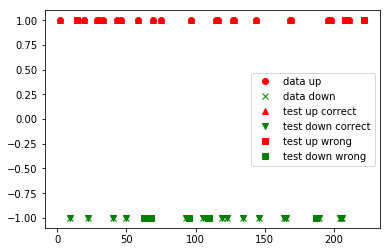

In [11]:
test_predict_nodes = random.sample(test_nodes, ntest)
test_predict_nodes.sort() 
tplabels = binary_labels[test_predict_nodes]

testframe = nodes_dataframe[(nodes_dataframe.test_node == True)]
predictions = testframe.prediction.apply(lambda x: pd.Series(np.squeeze(x)))
predictions.rename(columns={0: "mean_predict", 1:"var_predict"}, inplace=True)
nodes_dataframe.join(how="left", other=predictions)

pl_frame = testframe.sample(50)

pl.figure()
data_up, = pl.plot(pl_frame[pl_frame.binary_label==1].nodes, pl_frame[pl_frame.binary_label==1].binary_label,'ro',label="data up")
data_down, = pl.plot(pl_frame[pl_frame.binary_label==-1].nodes, pl_frame[pl_frame.binary_label==-1].binary_label,'gx',label="data down")


test_up_ok, = pl.plot(pl_frame[(pl_frame.binary_label==1)&(pl_frame.binary_prediction==1)].nodes,
                              pl_frame[(pl_frame.binary_label==1)&(pl_frame.binary_prediction==1)].binary_label,
                              'r^', label= "test up correct")
test_down_ok, = pl.plot(pl_frame[(pl_frame.binary_label==-1)&(pl_frame.binary_prediction==-1)].nodes,
                              pl_frame[(pl_frame.binary_label==-1)&(pl_frame.binary_prediction==-1)].binary_label,
                              'gv', label= "test down correct")

test_up_wrong, = pl.plot(pl_frame[(pl_frame.binary_label==1)&(pl_frame.binary_prediction==-1)].nodes,
                              pl_frame[(pl_frame.binary_label==1)&(pl_frame.binary_prediction==-1)].binary_label,
                              'rs', label= "test up wrong")
test_down_wrong, = pl.plot(pl_frame[(pl_frame.binary_label==-1)&(pl_frame.binary_prediction==1)].nodes,
                              pl_frame[(pl_frame.binary_label==-1)&(pl_frame.binary_prediction==1)].binary_label,
                              'gs', label= "test down wrong")

pl.legend(handles=[data_up, data_down, test_up_ok, test_down_ok,
                   test_up_wrong, test_down_wrong])

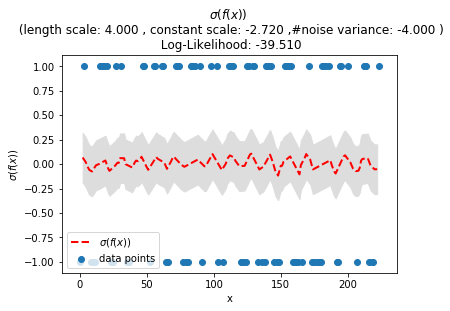

In [12]:
xstar_p = np.squeeze(test_nodes)
mean_p = np.squeeze(mean)
var_p = np.squeeze(np.reshape(var,(len(test_nodes),1)))
s = np.sqrt(var_p)

pl.figure()
pl.clf()

pl.gca().fill_between(predictions.index,(predictions.mean_predict- np.sqrt(predictions.var_predict)),(predictions.mean_predict+ np.sqrt(predictions.var_predict)),color="#dddddd")
latent, = pl.plot(predictions.index, predictions.mean_predict, 'r--', lw=2, label = "$\sigma(f(x))$")
loglikelihood = net_logPosterior(newtheta,G, dist, training_nodes, training_labels)
pl.title('$\sigma(f(x))$ \n (length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (newtheta[1], newtheta[0], newtheta[2], loglikelihood))
pl.xlabel('x')
pl.ylabel('$\sigma(f(x))$')
datapoints = pl.scatter(training_nodes,training_labels, label = "data points")
pl.legend(handles = [latent, datapoints])
#pl.scatter(test,tlabels)
pl.savefig('predict.png', bbox_inches='tight')

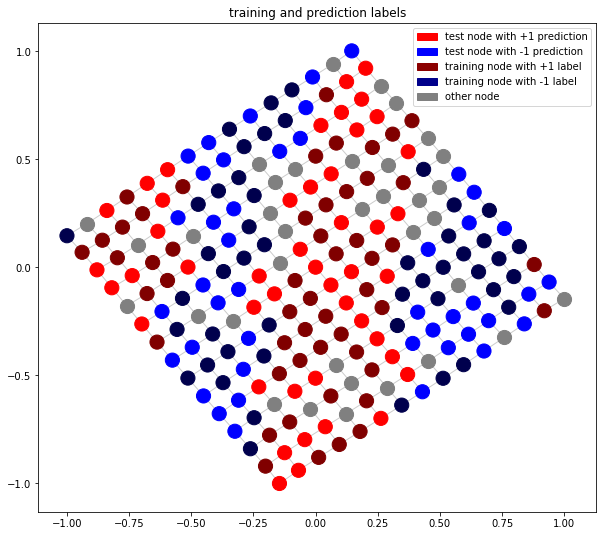

In [13]:
pl.figure(figsize=[10,9])
pl.title("training and prediction labels")
#cmap = pl.cm.bwr
#sm = pl.cm.ScalarMappable(cmap=cmap, norm=pl.Normalize(vmin -1, vmax= +1))
#sm.set_array([])
#cbar = pl.colorbar(sm)
red_binary_patch = mpatches.Patch(color="red", label='test node with +1 prediction')
blue_binary_patch = mpatches.Patch(color="blue", label='test node with -1 prediction')
darkred_binary_patch = mpatches.Patch(color="darkred", label= "training node with +1 label")
darkblue_binary_patch = mpatches.Patch(color="darkblue", label= "training node with -1 label")
grey_patch = mpatches.Patch(color="grey", label= "other node")
nx.draw_networkx_nodes(G,pos, nodelist=training_nodes, node_color=training_labels,with_labels=True, node_size=200, cmap=pl.cm.seismic)
nx.draw_networkx_nodes(G,pos, nodelist=test_nodes, node_color=nodes_dataframe.binary_prediction[nodes_dataframe.binary_prediction.notnull()],with_labels=True, node_size=200, cmap=pl.cm.bwr)
nx.draw_networkx_nodes(G,pos, nodelist=othernodes, node_color="gray",with_labels=True, node_size=200)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
#graph_labels = nx.draw_networkx_labels(G, pos=pos, font_color='white')
pl.legend(handles=[red_binary_patch, blue_binary_patch, darkred_binary_patch, 
                   darkblue_binary_patch, grey_patch])